Fase 0: Librerías importadas y estilo configurado.

--- Fase 1: Descomprimiendo archivos .gz ---
  -> Descomprimido: auth.log.2.gz -> auth.log.2.txt
  -> Descomprimido: auth.log.3.gz -> auth.log.3.txt
  -> Descomprimido: auth.log.4.gz -> auth.log.4.txt

--- Fase 2: Cargando datos de btmp (Intentos Fallidos) ---
Éxito: Se cargaron 86694 intentos fallidos desde btmp.

--- Fase 3: Cargando datos de auth.log (Eventos SSHD y LOGIN) ---
¡ÉXITO! Se cargaron 5461 eventos de inicio de sesión (remotos y locales).

--- Fase 4: Unificando y etiquetando el dataset ---
Dataset unificado y ordenado.
Distribución de eventos normales (0) vs. ataques (1):
is_attack
1    33561
0       42
Name: count, dtype: int64

--- Fase 5: Creando el dataset final con 8 características ---
  -> Calculando características de comportamiento y contexto...


Procesando diversidad de usuarios: 100%|██████████| 39/39 [00:02<00:00, 18.47it/s]



  -> Creando características avanzadas...

  -> Creando características de ritmo y temporalidad...
¡Dataset final con 8 características listo para el modelo de IA!

--- Fase 6: Guardando el dataset procesado en un archivo CSV ---
¡Éxito! El dataset ha sido guardado como: 'final_dataset_ciberseguridad_8_features.csv'

--- Fase 7: Preparando datos para el entrenamiento ---
Datos listos: 15020 para entrenamiento, 3756 para prueba.

--- Fase 7.5: Aplicando SMOTE para balancear los datos de entrenamiento ---
Distribución de clases después de SMOTE: {1: 14986, 0: 14986}

--- Fase 8: Entrenando el modelo XGBoost final ---
  -> ⏱️ Tiempo de entrenamiento: 0.04 segundos.
  -> ⏱️ Tiempo de inferencia para 3756 registros: 0.0023 segundos.

Modelo final entrenado. Evaluación de resultados:
              precision    recall  f1-score   support

  Normal (0)       0.88      0.88      0.88         8
  Ataque (1)       1.00      1.00      1.00      3748

    accuracy                           1.00   

C:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [07:39:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


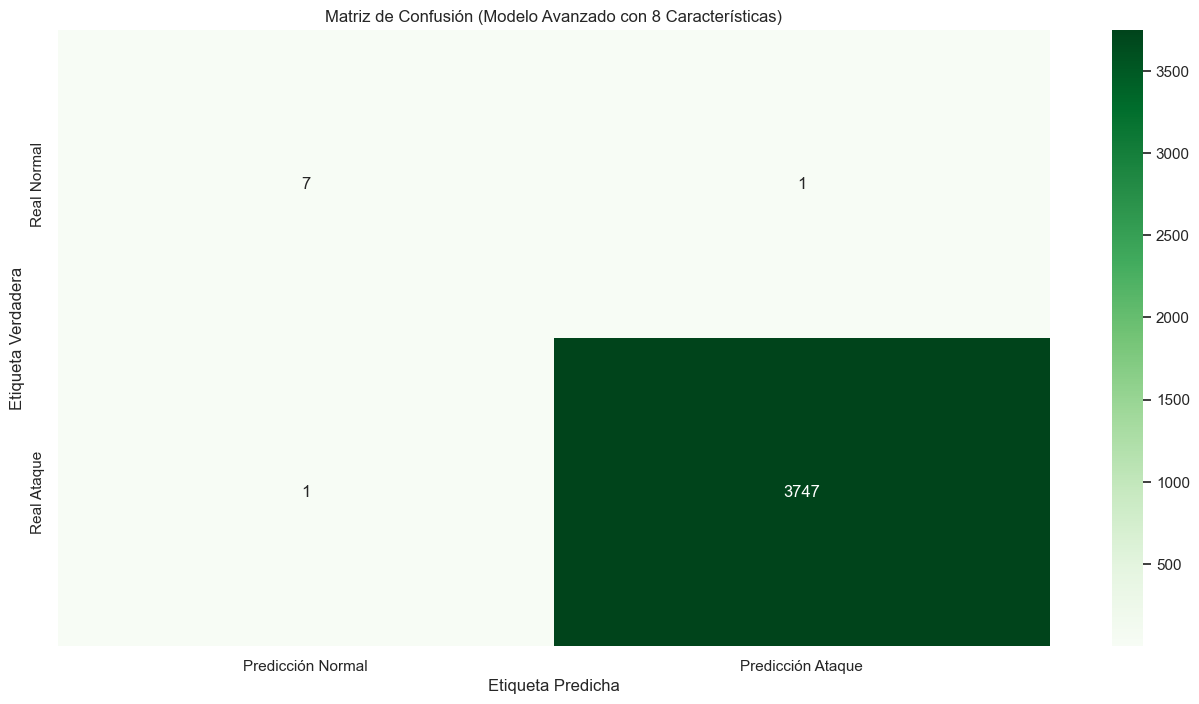


--- Fase 9: Explicando las predicciones del modelo final con SHAP ---

Gráfico de Resumen SHAP (Importancia de Características):


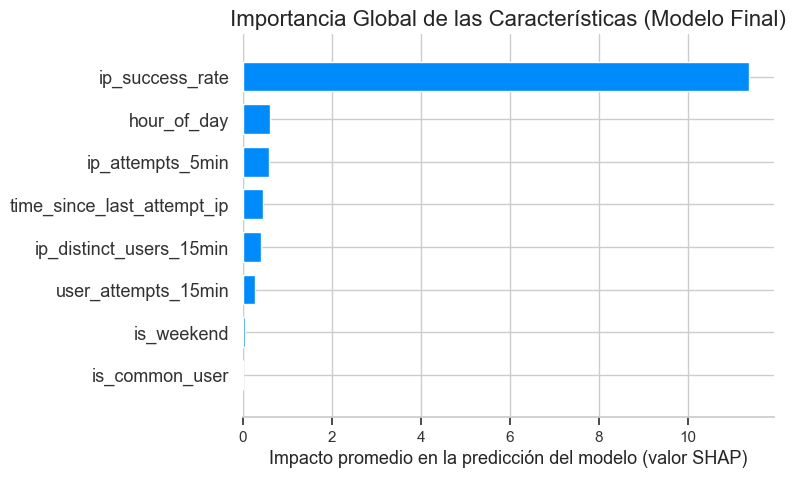


Gráfico de Enjambre SHAP (Análisis Detallado):


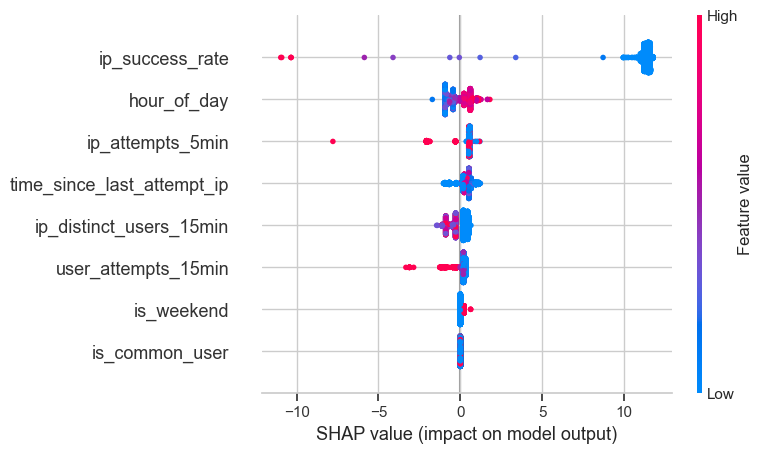

In [62]:
# ==============================================================================
# FASE 0: LIBRERÍAS Y CONFIGURACIÓN
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re
import gzip
import shutil
import time
from tqdm.auto import tqdm # Para la barra de progreso

# Importamos las librerías de Machine Learning al inicio
try:
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, confusion_matrix
    import xgboost as xgb
    import shap
    from imblearn.over_sampling import SMOTE
except ImportError:
    print("Instalando librerías necesarias: scikit-learn, xgboost, shap, imbalanced-learn...")
    # Si usas Jupyter, el signo de exclamación ejecuta comandos de terminal
    !pip install scikit-learn xgboost shap imbalanced-learn
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, confusion_matrix
    import xgboost as xgb
    import shap
    from imblearn.over_sampling import SMOTE

import numpy as np

# --- Configuración de Estilo para Gráficos ---
sns.set(style="whitegrid", palette="viridis")
plt.rcParams['figure.figsize'] = (16, 8)
print("Fase 0: Librerías importadas y estilo configurado.")

# ==============================================================================
# FASE 1: DESCOMPRIMIR ARCHIVOS .GZ
# ==============================================================================
print("\n--- Fase 1: Descomprimiendo archivos .gz ---")
gz_files = glob.glob('auth.log*.gz')
for gz_file in gz_files:
    txt_file = gz_file.replace('.gz', '.txt')
    try:
        with gzip.open(gz_file, 'rb') as f_in:
            with open(txt_file, 'wb') as f_out: shutil.copyfileobj(f_in, f_out)
        print(f"  -> Descomprimido: {gz_file} -> {txt_file}")
    except Exception as e:
        print(f"  -> Error al descomprimir {gz_file}: {e}")

# ==============================================================================
# FASE 2: CARGAR DATOS DE BTMP (INTENTOS FALLIDOS)
# ==============================================================================
print("\n--- Fase 2: Cargando datos de btmp (Intentos Fallidos) ---")
btmp_files = glob.glob('btmp*.txt')
btmp_data = []
btmp_pattern = re.compile(r"^(?P<user>\S+)\s+(?P<tty>\S+)\s+(?P<ip>\S+)\s+(?P<timestamp>\w+\s+\w+\s+\d+\s+\d{2}:\d{2}).*")
for file in btmp_files:
    with open(file, 'r', errors='ignore') as f:
        for line in f:
            if line.strip():
                match = btmp_pattern.match(line)
                if match:
                    data = match.groupdict()
                    if not re.match(r"\d{1,3}(\.\d{1,3}){3}", data['ip']): data['ip'] = 'local_login_failure'
                    data['timestamp'] += " 2025"
                    btmp_data.append(data)
btmp_df = pd.DataFrame(btmp_data)
if not btmp_df.empty:
    btmp_df['timestamp'] = pd.to_datetime(btmp_df['timestamp'], format='%a %b %d %H:%M %Y', errors='coerce').dt.tz_localize('UTC')
    btmp_df.dropna(subset=['timestamp'], inplace=True)
    print(f"Éxito: Se cargaron {len(btmp_df)} intentos fallidos desde btmp.")
else:
    print("Error: No se pudieron cargar datos de btmp.")

# ==============================================================================
# FASE 3: CARGAR DATOS DE AUTH.LOG (UNIVERSAL: SSHD Y LOGIN)
# ==============================================================================
print("\n--- Fase 3: Cargando datos de auth.log (Eventos SSHD y LOGIN) ---")
auth_files = glob.glob('auth.log*')
auth_data = []
auth_pattern = re.compile(r"^(?P<timestamp>\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\.\d{6}\+\d{2}:\d{2})")
for file in auth_files:
    if file.endswith('.gz'): continue
    with open(file, 'rt', errors='ignore') as f:
        for line in f:
            if 'sshd' not in line and 'login' not in line: continue
            match = auth_pattern.match(line)
            if not match: continue
            timestamp = match.group('timestamp')
            status, user, ip = None, None, None
            if 'sshd' in line:
                if "Accepted password for" in line:
                    status = "Accepted"
                    parts = re.search(r"for\s+([\w\d\-\_]+)\s+from\s+([\d\.]+)", line)
                    if parts: user, ip = parts.groups()
                elif "Failed password for" in line:
                    status = "Failed"
                    parts = re.search(r"for\s+(?:invalid\suser\s+)?([\w\d\-\_]+)\s+from\s+([\d\.]+)", line)
                    if parts: user, ip = parts.groups()
            elif 'login' in line:
                if "session opened for user" in line:
                    status = "Accepted"
                    parts = re.search(r"session opened for user\s+([\w\d\-\_]+)", line)
                    if parts: user, ip = parts.group(1), "local_login"
                elif "FAILED LOGIN" in line:
                    status = "Failed"
                    parts = re.search(r"FOR\s+'([\w\d\-\_]+)'", line)
                    if parts: user, ip = parts.group(1), "local_login"
            if status:
                auth_data.append({"timestamp": timestamp, "status": status, "user": user, "ip": ip})
auth_df = pd.DataFrame(auth_data)
if not auth_df.empty:
    auth_df['timestamp'] = pd.to_datetime(auth_df['timestamp'], errors='coerce').dt.tz_convert('UTC')
    print(f"¡ÉXITO! Se cargaron {len(auth_df)} eventos de inicio de sesión (remotos y locales).")
else:
    print("Error: No se pudieron cargar datos de sshd o login desde auth.log.")

# ==============================================================================
# FASE 4: UNIFICAR, ETIQUETAR Y ORDENAR
# ==============================================================================
print("\n--- Fase 4: Unificando y etiquetando el dataset ---")
if not auth_df.empty: auth_df['is_attack'] = auth_df['status'].apply(lambda x: 1 if x == 'Failed' else 0)
if not btmp_df.empty: btmp_df['is_attack'] = 1
common_columns = ['timestamp', 'user', 'ip', 'is_attack']
combined_df = pd.concat([
    auth_df[common_columns] if not auth_df.empty else pd.DataFrame(columns=common_columns),
    btmp_df[common_columns] if not btmp_df.empty else pd.DataFrame(columns=common_columns)
], ignore_index=True).drop_duplicates()
combined_df.sort_values(by='timestamp', inplace=True)
print("Dataset unificado y ordenado.")
print("Distribución de eventos normales (0) vs. ataques (1):")
print(combined_df['is_attack'].value_counts())

# ==============================================================================
# FASE 5: INGENIERÍA DE CARACTERÍSTICAS (VERSIÓN FINAL CON 8 CARACTERÍSTICAS)
# ==============================================================================
print("\n--- Fase 5: Creando el dataset final con 8 características ---")
if not combined_df.empty and pd.api.types.is_datetime64_any_dtype(combined_df['timestamp']):
    df = combined_df.set_index('timestamp').sort_index()
    df = df[~df.index.duplicated(keep='first')]
    
    # Características 1-4
    print("  -> Calculando características de comportamiento y contexto...")
    df['ip_attempts_5min'] = df.groupby('ip')['ip'].rolling('5min', min_periods=1).count().reset_index(0, drop=True)
    def calculate_rolling_nunique(series, window='15min'):
        results = []
        for current_time in series.index:
            start_time = current_time - pd.Timedelta(window)
            nunique = series.loc[start_time:current_time].nunique()
            results.append(nunique)
        return pd.Series(results, index=series.index)
    all_results = []
    grouped_by_ip = df.groupby('ip')
    for ip, group in tqdm(grouped_by_ip, desc="Procesando diversidad de usuarios"):
        group_results = calculate_rolling_nunique(group['user'])
        all_results.append(group_results)
    if all_results: df['ip_distinct_users_15min'] = pd.concat(all_results)
    df['hour_of_day'] = df.index.hour
    common_attack_users = ['root', 'admin', 'user', 'test', 'oracle', 'postgres', 'ubuntu']
    df['is_common_user'] = df['user'].isin(common_attack_users).astype(int)

    # Características 5-6
    print("\n  -> Creando características avanzadas...")
    df['ip_success_count'] = (df['is_attack'] == 0).groupby(df['ip']).cumsum()
    df['ip_total_count'] = df.groupby(df['ip']).cumcount() + 1
    df['ip_success_rate'] = df['ip_success_count'] / df['ip_total_count']
    df['user_attempts_15min'] = df.groupby('user')['user'].rolling('15min', min_periods=1).count().reset_index(0, drop=True)
    df.drop(columns=['ip_success_count', 'ip_total_count'], inplace=True)
    
    # Características 7-8
    print("\n  -> Creando características de ritmo y temporalidad...")
    df['time_since_last_attempt_ip'] = df.index.to_series().groupby(df['ip']).diff().dt.total_seconds().fillna(0)
    df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)

    df.fillna(0, inplace=True)
    print("¡Dataset final con 8 características listo para el modelo de IA!")
else:
    print("No hay datos suficientes o el timestamp no es válido para crear características.")

# ==============================================================================
# FASE 6: EXPORTAR EL DATASET COMPLETO A CSV
# ==============================================================================
print("\n--- Fase 6: Guardando el dataset procesado en un archivo CSV ---")
csv_file_name = 'final_dataset_ciberseguridad_8_features.csv'
if 'df' in locals() and not df.empty:
    try:
        df.to_csv(csv_file_name)
        print(f"¡Éxito! El dataset ha sido guardado como: '{csv_file_name}'")
    except Exception as e:
        print(f"Ocurrió un error al guardar el archivo CSV: {e}")
else:
    print("No se puede guardar el archivo porque el DataFrame 'df' está vacío.")

# ==============================================================================
# FASE 7: PREPARACIÓN PARA EL MODELO DE IA
# ==============================================================================
print("\n--- Fase 7: Preparando datos para el entrenamiento ---")
features = [
    'ip_attempts_5min', 
    'ip_distinct_users_15min', 
    'hour_of_day', 
    'is_common_user',
    'ip_success_rate',
    'user_attempts_15min',
    'time_since_last_attempt_ip',
    'is_weekend'
]
target = 'is_attack'
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Datos listos: {len(X_train)} para entrenamiento, {len(X_test)} para prueba.")

# ==============================================================================
# FASE 7.5: BALANCEO CON SMOTE
# ==============================================================================
print("\n--- Fase 7.5: Aplicando SMOTE para balancear los datos de entrenamiento ---")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("Distribución de clases después de SMOTE:", y_train_smote.value_counts().to_dict())

# ==============================================================================
# FASE 8: ENTRENAMIENTO Y EVALUACIÓN DEL MODELO FINAL
# ==============================================================================
print("\n--- Fase 8: Entrenando el modelo XGBoost final ---")
model_final = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
start_time_train = time.time()
model_final.fit(X_train_smote, y_train_smote)
training_time = time.time() - start_time_train
print(f"  -> ⏱️ Tiempo de entrenamiento: {training_time:.2f} segundos.")

start_time_pred = time.time()
y_pred_final = model_final.predict(X_test)
prediction_time = time.time() - start_time_pred
print(f"  -> ⏱️ Tiempo de inferencia para {len(X_test)} registros: {prediction_time:.4f} segundos.")


print("\nModelo final entrenado. Evaluación de resultados:")
print(classification_report(y_test, y_pred_final, target_names=['Normal (0)', 'Ataque (1)']))
print("Matriz de Confusión Final:")
cm_final = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Greens', xticklabels=['Predicción Normal', 'Predicción Ataque'], yticklabels=['Real Normal', 'Real Ataque'])
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión (Modelo Avanzado con 8 Características)')
plt.show()

# ==============================================================================
# FASE 9: IA EXPLICABLE (XAI) CON EL MODELO FINAL
# ==============================================================================
print("\n--- Fase 9: Explicando las predicciones del modelo final con SHAP ---")
explainer_final = shap.Explainer(model_final, X_train_smote)
shap_values_final = explainer_final(X_test)
print("\nGráfico de Resumen SHAP (Importancia de Características):")
shap.summary_plot(shap_values_final, X_test, plot_type="bar", show=False)
plt.title('Importancia Global de las Características (Modelo Final)', fontsize=16)
plt.xlabel('Impacto promedio en la predicción del modelo (valor SHAP)')
plt.show()
print("\nGráfico de Enjambre SHAP (Análisis Detallado):")
shap.summary_plot(shap_values_final, X_test, show=False)
plt.show()


--- Fase 10: Analizando aciertos específicos del modelo ---

--- Analizando un caso de 'ES ATAQUE' (Índice: 0) ---

Características del evento:
ip_attempts_5min                 1.000000
ip_distinct_users_15min          1.000000
hour_of_day                      3.000000
is_common_user                   0.000000
ip_success_rate                  0.000000
user_attempts_15min              1.000000
time_since_last_attempt_ip    2382.241799
is_weekend                       0.000000
Name: 2025-09-29 03:07:00+00:00, dtype: float64


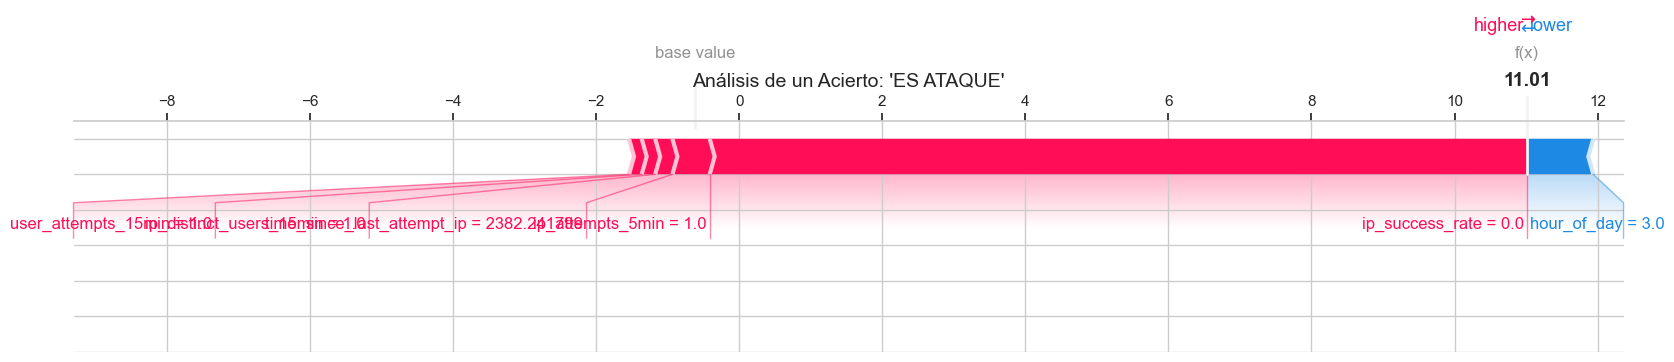


--- Analizando un caso de 'NO ES ATAQUE' (Índice: 533) ---

Características del evento:
ip_attempts_5min               3.000000
ip_distinct_users_15min        1.000000
hour_of_day                   15.000000
is_common_user                 0.000000
ip_success_rate                1.000000
user_attempts_15min            3.000000
time_since_last_attempt_ip     2.404925
is_weekend                     0.000000
Name: 2025-10-09 15:03:26.118538+00:00, dtype: float64


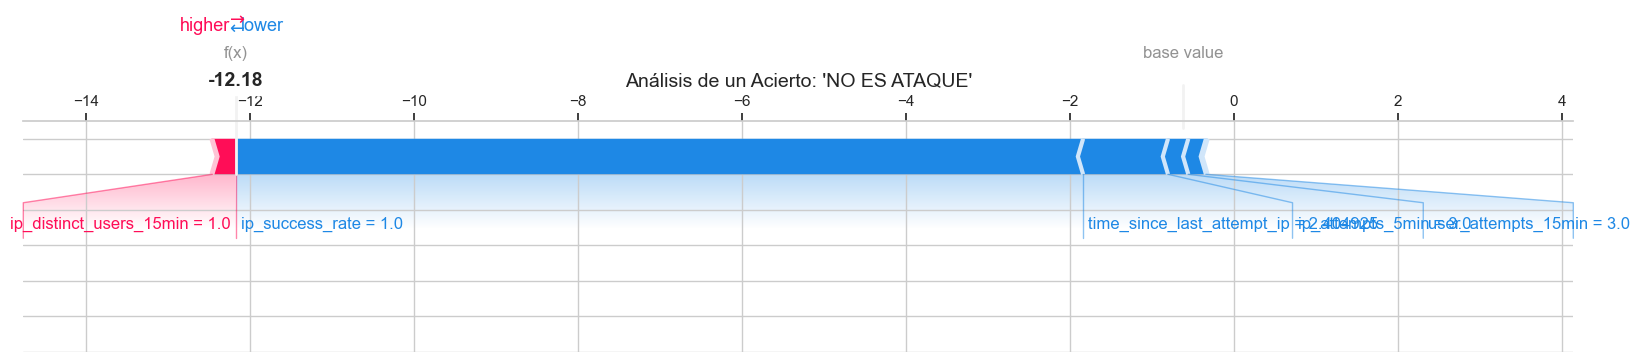

In [58]:
# ==============================================================================
# FASE 10: ANÁLISIS DE ACIERTOS DEL MODELO (Versión Simplificada)
# ==============================================================================
print("\n--- Fase 10: Analizando aciertos específicos del modelo ---")

# --- CASO 1: EL MODELO DICE "ES ATAQUE" Y FUE UN ATAQUE (VERDADERO POSITIVO) ---
# Buscamos un evento que era un ataque real (y_test == 1) y el modelo
# lo predijo correctamente como ataque (y_pred_final == 1).
es_ataque_idx = np.where((y_test == 1) & (y_pred_final == 1))[0]

if len(es_ataque_idx) > 0:
    idx = es_ataque_idx[0] # Tomamos el primer ejemplo claro de un ataque
    print(f"\n--- Analizando un caso de 'ES ATAQUE' (Índice: {idx}) ---")
    print("\nCaracterísticas del evento:")
    print(X_test.iloc[idx])

    # Generamos el gráfico "force plot" para visualizar la decisión.
    # Las fuerzas rojas (features de ataque) empujan la predicción hacia la derecha.
    shap.force_plot(
        explainer_final.expected_value,
        shap_values_final[idx].values,
        X_test.iloc[idx],
        matplotlib=True,
        show=False
    )
    plt.title("Análisis de un Acierto: 'ES ATAQUE'", fontsize=14)
    plt.show()
else:
    print("\nNo se encontraron ejemplos de ataques correctamente identificados.")

# --- CASO 2: EL MODELO DICE "NO ES ATAQUE" Y NO FUE UN ATAQUE (VERDADERO NEGATIVO) ---
# Buscamos un evento que NO era un ataque (y_test == 0) y el modelo
# lo predijo correctamente como normal (y_pred_final == 0).
no_es_ataque_idx = np.where((y_test == 0) & (y_pred_final == 0))[0]

if len(no_es_ataque_idx) > 0:
    idx = no_es_ataque_idx[0] # Tomamos el primer ejemplo claro de un evento normal
    print(f"\n--- Analizando un caso de 'NO ES ATAQUE' (Índice: {idx}) ---")
    print("\nCaracterísticas del evento:")
    print(X_test.iloc[idx])

    # Generamos el gráfico "force plot" para visualizar la decisión.
    # Las fuerzas azules (features de normalidad) empujan la predicción hacia la izquierda.
    shap.force_plot(
        explainer_final.expected_value,
        shap_values_final[idx].values,
        X_test.iloc[idx],
        matplotlib=True,
        show=False
    )
    plt.title("Análisis de un Acierto: 'NO ES ATAQUE'", fontsize=14)
    plt.show()
else:
    print("\nNo se encontraron ejemplos de eventos normales correctamente identificados.")